In [ ]:
import os
import re
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers, datasets
from keras import Model
from keras import applications
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.initializers import Constant
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.advanced_activations import PReLU
from keras.initializers import he_normal, he_uniform
from keras.callbacks import LearningRateScheduler

In [ ]:
# seems to reduce the chance of gpu errors, also doesn't blindly allocate all vram 

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [ ]:
batch_size = 64
np.random.seed(0)

In [4]:
# validation
datagen_aug = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2, 
                                 horizontal_flip=True,
                                 width_shift_range=4,
                                 height_shift_range=4)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)



train_generator = datagen_aug.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='training')

validation_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform(), input_shape=(32, 32, 3)))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, kernel_regularizer=l2(2e-3), kernel_initializer=he_uniform()))
model.add(PReLU(alpha_initializer=Constant(value=0.25)))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, kernel_regularizer=l2(1e-4)))
model.add(Activation('softmax'))

opt = optimizers.Adam(lr=.01, epsilon=1e-4)#, decay=2e-5)
#opt = optimizers.SGD(lr=.02, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
#Adam
def step_scheduler(epoch, lr):
    if epoch < 6:
        return lr/2
    return 1e-4 - 2e-7*epoch

#model.load_weights('test.h5')

history = model.fit_generator(train_generator,
                              epochs=500,
                              workers=2, # weirdly enough 3 works best (training on 6c/12t)
                              validation_data=validation_generator,
                              steps_per_epoch=40000 // batch_size,
                              validation_steps=10000 // batch_size,
                              callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

In [77]:
import pickle
with open('bench_acc.p', 'wb') as fp:
    pickle.dump(history.history['accuracy'], fp)
with open('bench_val.p', 'wb') as fp:
    pickle.dump(history.history['val_accuracy'], fp)

In [66]:
import pickle
with open ('bench_acc.p', 'rb') as fp:
    acc = pickle.load(fp)
with open('bench_val.p', 'rb') as fp:
    val = pickle.load(fp)

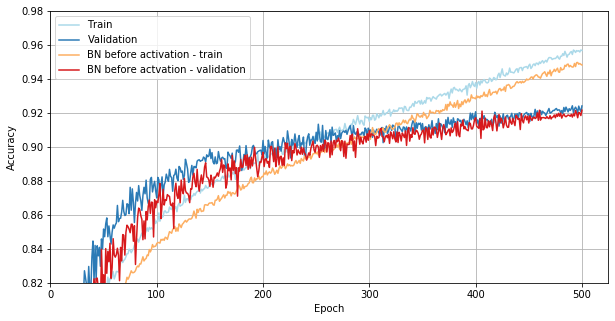

In [104]:
from scipy.interpolate import UnivariateSpline

f = plt.figure(figsize=(10,5))

x = range(1, 501)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
plt.plot(x, acc, color='#abd9e9')
plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'BN before activation - train', 'BN before actvation - validation'], loc='upper left')
plt.ylim(0.82, 0.98)
plt.xlim(0)
plt.grid()
plt.show()

#f.savefig('report-bn.svg', bbox_inches='tight')

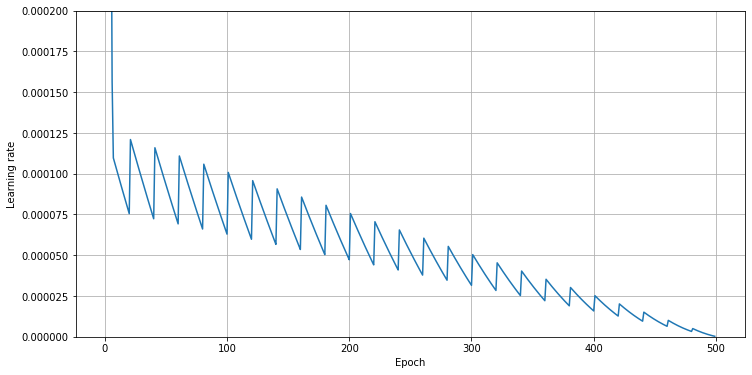

In [39]:
@np.vectorize
def lr(epoch):
    if epoch < 7:
        return .01*.5**epoch
    return (1e-4 - 2e-7*(epoch-1)) * (1.26 - (epoch-1)%20/40)


f = plt.figure(figsize=(12,6))

x = range(1, 500)

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)
plt.ylim(0, 0.00020)
#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
plt.plot(x, lr(x))
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.grid()
plt.show()
#f.savefig('lr2.svg', bbox_inches='tight')

In [15]:
model.save_weights('final.h5')

In [14]:
model.load_weights('final.h5')

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test',
                                                   target_size=(32, 32),
                                                   batch_size=128,
                                                   shuffle=False)

Found 300000 images belonging to 1 classes.


In [12]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

2344/2344 [==============================] - 297s 127ms/step


In [13]:
indices = np.argmax(pred, axis=1)
ids = [int(re.sub('\D+', '', name)) for name in test_generator.filenames]
flipped = {v:k for k,v in validation_generator.class_indices.items()}
labels = [flipped[i] for i in indices]
submission = pd.DataFrame({'id':ids, 'label':labels}).sort_values(['id']).reset_index(drop=True)

In [14]:
submission.to_csv('submission.csv', index=False)